# NN draw

In [13]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
from jaxopt import ProjectedGradient

In [3]:
from rebayes_mini.methods import low_rank_last_layer as lrll

In [4]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## The model objective function

In [5]:
class TrueMLP(nn.Module):
    n_hidden: int = 50
    initializer = nn.initializers.normal

    def setup(self):
        self.hidden_1 = nn.Dense(
            50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x) / 100
        return x

In [55]:
key = jax.random.PRNGKey(314)
key_init, key_surrogate = jax.random.split(key)

In [56]:
dim = 20 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

## Surrogate model

In [57]:
class MLP(nn.Module):
    n_hidden: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

### Components

In [126]:
def projection(params, hparams):
    return jnp.clip(params, 0.0, 1.0)


def minimise_project(guess_init, params_hidden, params_ll):
    fn_sampled = lambda x: -agent.mean_fn(params_hidden, params_ll, x).squeeze()
    opt = ProjectedGradient(
        fun=fn_sampled,
        projection=projection,  # Enforce boundary constraints
        stepsize=1e-2,
        tol=1e-5,
        # maxiter=1000,
    )
    res = opt.run(guess_init)
    return res

def step(state, t, key, agent, guess_init):
    bel, x, y = state
    key_step = jax.random.fold_in(key, t)
    
    ll_params = agent.sample_params_last_layer(key_step, bel).squeeze()
    # compute location of next best estimate and actual estimate
    x_next = minimise_project(guess_init, bel.mean_hidden, ll_params).params
    y_next = base_model.apply(params_base, x_next)
    # update belief based on true observations
    bel = agent.update(bel, y_next.squeeze(), x_next)

    out = {
        "x": x_next.squeeze(),
        "y": y_next.squeeze()
    }

    state_next = (bel, x_next, y_next)
    return state_next, out

### Run experiment

In [127]:
key_init_params, key_init_x, key_eval, key_guess = jax.random.split(key_surrogate, 4)

In [128]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, X_init)
guess_init = jax.random.uniform(key_init, dim)

def cov_fn(y): return 1e-2
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=100,
    dynamics_hidden=0.0, dynamics_last=0.0,
)

_step = partial(step, key=key_eval, agent=agent, guess_init=guess_init)
steps = jnp.arange(500)

x_init = jax.random.uniform(key_init_x, (dim))
y_init = base_model.apply(params_base, x_init)
bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-3, # parameters should not vary much from their initial estimate
    cov_last=5.0
)

state_init = (bel_init, x_init, y_init)
bel_final, hist = jax.lax.scan(_step, state_init, steps)

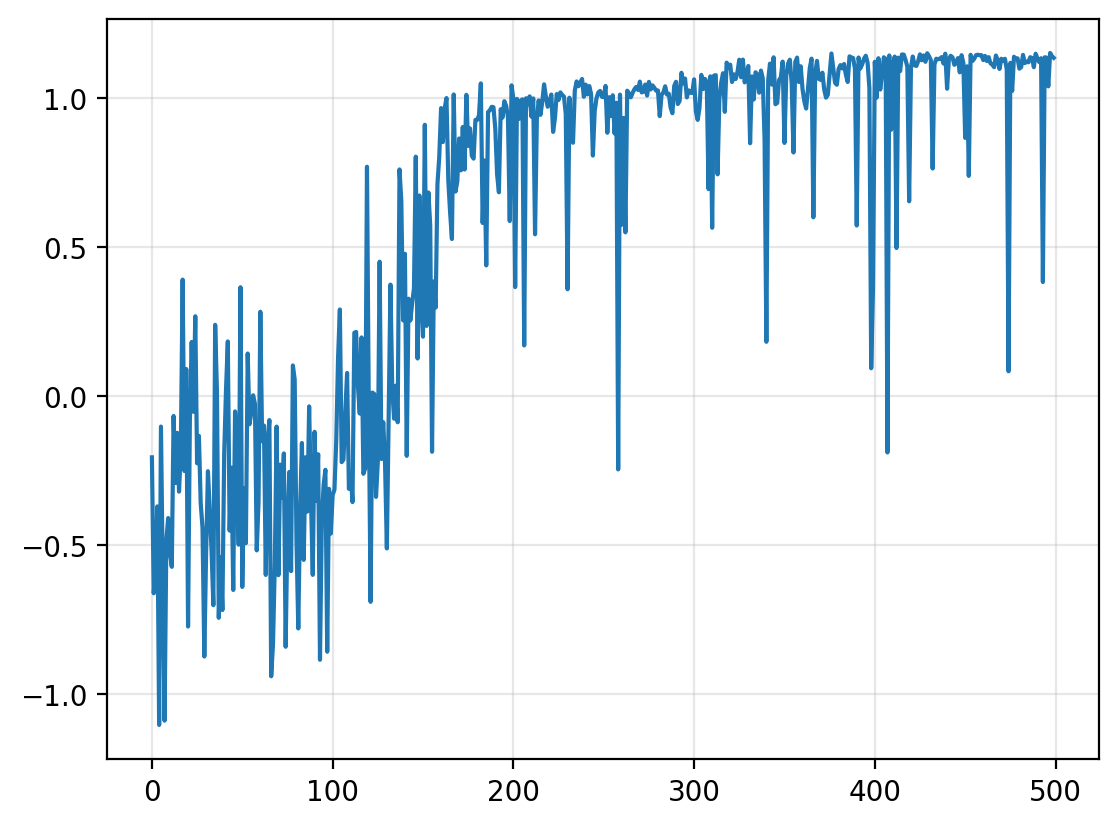

In [129]:
plt.plot(hist["y"])
plt.grid(alpha=0.3)

## Best optimum (projected gradient descent)

In [130]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=projection,  # Enforce boundary constraints
    stepsize=1e-2,
    # tol=1e-5
    maxiter=2000
)

res = opt.run(init_params=guess_init)

In [131]:
yopt = base_model.apply(params_base, res.params)
yopt

Array([1.1460258], dtype=float32)

In [132]:
hist["y"][-1]

Array(1.1352355, dtype=float32)

Text(0, 0.5, 'max found')

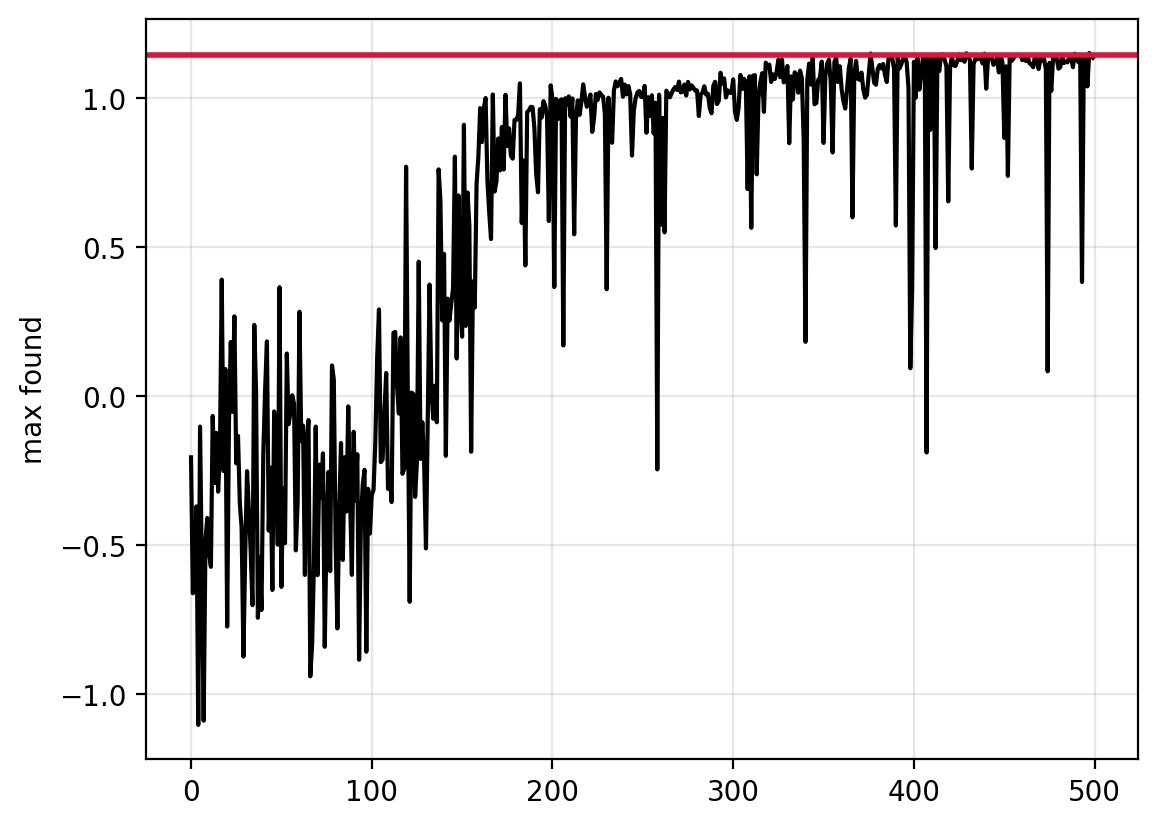

In [133]:
plt.plot(hist["y"], c="black")
plt.axhline(y=yopt, c="crimson", linewidth=2)
plt.grid(alpha=0.3)
plt.ylabel("max found")